### Imports

In [13]:
from typing import Tuple
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, random_split, DataLoader

import aim

In [2]:
import os, sys
sys.path.append(os.path.abspath('..'))

from src.models.unet import UNet
from src.training.metrics import dice_loss
from src.training.metrics import evaluate
from src.training.train import train
from src.data.datasets import ACDCDataset


### Fetch dataset

In [5]:

dataset = ACDCDataset(path='../../training/', tagged=False, verbose=1)

Loaded saved dataset of 952 images from /worskpace/dev/tagroi/checkpoints/cine.pt


In [7]:
train_set, val_set, _ = random_split(dataset, [8, 4, 940], generator=torch.Generator().manual_seed(42))
loader_train = DataLoader(train_set, batch_size=4, shuffle=True)
loader_val = DataLoader(val_set, batch_size=4, shuffle=False)

### Instantiate model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
model = UNet(n_channels=1, n_classes=4, bilinear=True).double()
saved_model = torch.load('../checkpoints/model/model_v1.pt')
if isinstance(saved_model, nn.DataParallel):  # Extract UNet if saved model is parallelized
    saved_model = saved_model.module
model.load_state_dict(saved_model.state_dict())

if device.type == 'cuda':
    model = nn.DataParallel(model).to(device)
    model.n_classes = model.module.n_classes

In [10]:
from torchvision.models.segmentation import deeplabv3_resnet50

pmodel = deeplabv3_resnet50(pretrained=True, progress=True)

### Train model

In [18]:
train(model, run=aim.Run(), loader_train=loader_train, loader_val=loader_val, device=device)

Trying to start Run on repository /worskpace/dev/tagroi/notebooks, which is out of date. Please upgrade repository with the following command: `aim upgrade --repo /worskpace/dev/tagroi/notebooks 2to3`.


RuntimeError: 

### Evaluate model outputs on validation set

In [7]:
example, label = next(iter(loader_val))
out = pmodel(example)

example.shape, label.shape, out.shape

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[4, 1, 256, 256] to have 3 channels, but got 1 channels instead

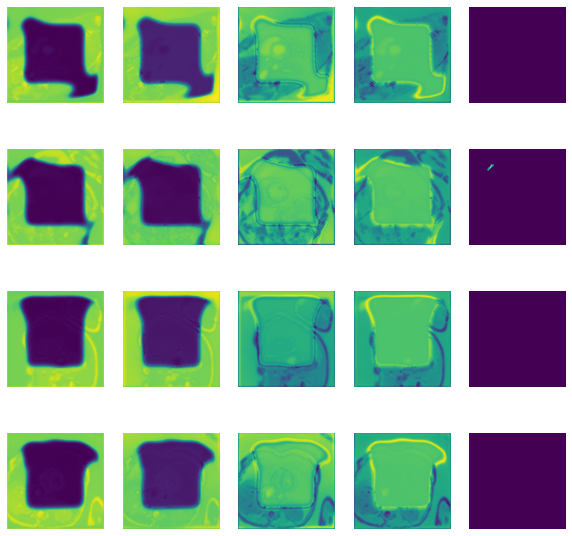

In [28]:
predicted_mask = F.softmax(out, dim=1).argmax(dim=1).cpu().detach().numpy().copy()

fig, ax = plt.subplots(4, 5, figsize=(10, 10))

for i in range(4):
    for j in range(4):
        ax[i, j].imshow(out.cpu().detach().numpy()[i, j])
        ax[i, j].axis('off')

    ax[i, 4].imshow(predicted_mask[i]), ax[i, 4].axis('off')

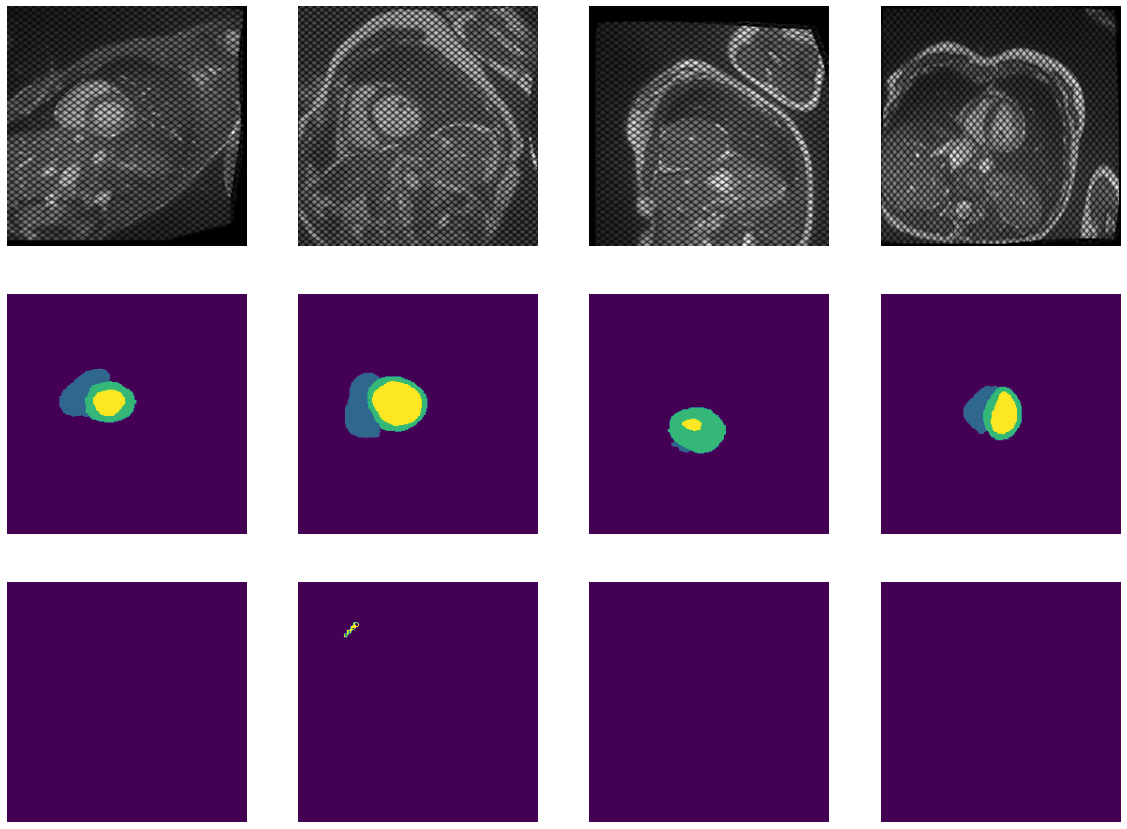

In [29]:
fig, ax = plt.subplots(3, 4, figsize=(20, 15))

for i in range(0, 4):
    ax[0, i % 5].imshow(example[i, 0], cmap='gray')
    ax[1, i % 5].imshow(label[i], alpha=1)
    ax[2, i % 5].imshow(predicted_mask[i], alpha=1.)
    ax[0, i % 5].axis('off'), ax[1, i % 5].axis('off'), ax[2, i % 5].axis('off')